# Data Science and NLP for Customer Review Analysis

This notebook shows analysis on real hotel review data crawled from Tripadvisor to automatically identify positive and negative keywords and phrases associated with hotels and to better understand characteristics of data analysis tools, extracting explanatory review summaries, and human reviewing behavior.


In [1]:
# install twython

In [191]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shagun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shagun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/shagun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/shagun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Functions

In [40]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [41]:
# Regular Data Transformation
def dataFrameTransformation(hotelDf, k=500):
    reviews = hotelDf['reviewColumn'].as_matrix()
     
    wnLemm = nltk.WordNetLemmatizer()
    stop = set(stopwords.words('english'))
    
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([wnLemm.lemmatize(word.lower(), 'v')
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
            
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    #finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth','reviewColumn','vader']].join(freqReviewDf)
    return topk, finaldf

### Noun Phrases

In [42]:
text = """The oneself."""
tagger = PerceptronTagger()
# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
pos_tag = tagger.tag
taggedToks = pos_tag(re.findall(r'\w+', text))
#taggedToks

In [43]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [44]:
# Create phrase tree
chunker = nltk.RegexpParser(grammar)
tree= chunker.parse(taggedToks)

In [45]:
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [46]:
# Traverse tree and get noun phrases
npTokenList = [word for word in get_terms(tree)]

npTokenList

[]

In [47]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [48]:
finalList = flatten(npTokenList)

In [49]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, k=500):
    reviews = hotelDf['reviewColumn'].as_matrix()

    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [50]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [51]:
# Simple example of getting pairwise mutual information of a term
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = sum(df['groundTruth']==i)/len(df)
            py = sum(df[x]==j)/len(df)
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log10((pxy+0.0001)/(px*py))
            else:
                pmi = math.log10(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

In [52]:
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    py = sum(df[x]==1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log10((pxy+0.0001)/(px*py))
    else:
        pmi = math.log10(pxy/(px*py))
    return pmi

In [53]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

### Import Data

In [16]:
# Read data from csv
dataDf = pandas.read_csv('reviews.csv', encoding = "utf-8")
dataDf.columns=['idNum','filePath','hotelName','reviewColumn','ratingScore','groundTruth']

In [17]:
# drop filepath
hotelDf = dataDf.drop('filePath', 1)

# drop any rows with incomplete data 
hotelDf = hotelDf.dropna()

# binarize ground truth rating. Positive = 1, Negative = 0 
#hotelDf = hotelDf.replace({'groundTruth': {'positive': 1, 'negative': 0}})
hotelDf.head()

,idNum,hotelName,reviewColumn,ratingScore,groundTruth
0,135454401,Halifax Marriott Harbourfront Hotel,We had a fantastic stay at the Marriott in Hal...,5,positive
1,135018891,Halifax Marriott Harbourfront Hotel,We stayed at Marriot Harbourfront for our anni...,3,negative
2,135712047,Halifax Marriott Harbourfront Hotel,The name Harbourfront says it all. On the boar...,5,positive
3,135739749,Halifax Marriott Harbourfront Hotel,The absolute best thing about this hotel is th...,4,positive
4,135884572,Halifax Marriott Harbourfront Hotel,If you want a wonderful place to stay in Halif...,5,positive


## Q1. Sentiment Analysis and Aggregation

In [18]:
# Calculate vader sentiment score
reviews = hotelDf['reviewColumn'].as_matrix()
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewColumn','vader'])
reviewDF.head()

100%|██████████| 1407/1407 [00:01<00:00, 757.72it/s]


,reviewColumn,vader
0,We had a fantastic stay at the Marriott in Hal...,0.9506
1,We stayed at Marriot Harbourfront for our anni...,0.9985
2,The name Harbourfront says it all. On the boar...,0.8658
3,The absolute best thing about this hotel is th...,0.9855
4,If you want a wonderful place to stay in Halif...,0.9637


In [19]:
hotelDfComplete = pandas.merge(hotelDf, reviewDF, on='reviewColumn')
hotelDfComplete.head()

,idNum,hotelName,reviewColumn,ratingScore,groundTruth,vader
0,135454401,Halifax Marriott Harbourfront Hotel,We had a fantastic stay at the Marriott in Hal...,5,positive,0.9506
1,135018891,Halifax Marriott Harbourfront Hotel,We stayed at Marriot Harbourfront for our anni...,3,negative,0.9985
2,135712047,Halifax Marriott Harbourfront Hotel,The name Harbourfront says it all. On the boar...,5,positive,0.8658
3,135739749,Halifax Marriott Harbourfront Hotel,The absolute best thing about this hotel is th...,4,positive,0.9855
4,135884572,Halifax Marriott Harbourfront Hotel,If you want a wonderful place to stay in Halif...,5,positive,0.9637


In [20]:
vadermean = hotelDfComplete["vader"].mean()
groundmean = hotelDfComplete["ratingScore"].mean()

print("Average Vader Compound Sentiment Score:", vadermean)
print("Average Ground Truth (ratingScore) Sentiment:", groundmean)

Average Vader Compound Sentiment Score: 0.8289001421464094
Average Ground Truth (ratingScore) Sentiment: 4.253731343283582


### a) Compute average Vader sentiment and average ground truth rating per hotel

- Average Vader Compound Sentiment Score: 0.829
- Average Ground Truth Sentiment: 4.25

### b)  Rank hotels by
1. Average Ground Truth Sentiment
2. Average Vader Compound Sentiment Score
#### Show both top-5 and bottom-5 for both ranking methods. Do they agree or are there interesting differences?

In [21]:
vaderRank = hotelDfComplete.sort_values(by=['vader'],ascending = False)
vaderRank.head(5)

,idNum,hotelName,reviewColumn,ratingScore,groundTruth,vader
58,406595123,Prince George Hotel,I unexpectedly found myself in Nova Scotia ove...,4,positive,0.9993
799,115819885,Comfort Hotel Bayer\'s Lake,"We stayed just one night at this brand new, lo...",5,positive,0.9990
847,190403186,Comfort Hotel Bayer\'s Lake,My wife her sister and myself returned to this...,5,positive,0.9985
1339,142243250,Best Western Plus Chocolate Lake Hotel,Deservedly popular lake-front hotel is in a be...,5,positive,0.9985
1,135018891,Halifax Marriott Harbourfront Hotel,We stayed at Marriot Harbourfront for our anni...,3,negative,0.9985


In [22]:
groundTruthRank = hotelDfComplete.sort_values(by=['ratingScore', 'vader'], ascending = False)
groundTruthRank.head()

,idNum,hotelName,reviewColumn,ratingScore,groundTruth,vader
799,115819885,Comfort Hotel Bayer\'s Lake,"We stayed just one night at this brand new, lo...",5,positive,0.9990
847,190403186,Comfort Hotel Bayer\'s Lake,My wife her sister and myself returned to this...,5,positive,0.9985
1339,142243250,Best Western Plus Chocolate Lake Hotel,Deservedly popular lake-front hotel is in a be...,5,positive,0.9985
599,2379782,Delta Hotels by Marriott Halifax,My wife and I visited Nova Scotia and the east...,5,positive,0.9983
39,540989069,Halifax Marriott Harbourfront Hotel,"for the sticklers, i know its not a 5 star lik...",5,positive,0.9982


There are differences between the two ranking methods. For example, the highest vader score has a ratingScore of only 4 (maximum value = 5). Another top 5 vader score has a ratingScore of 3 and the groundTruth value negative. Simmilary, some reviews with a rating score of 5 have a vader score within the range [0,-0.5].

## Q2. Frequency Analysis

In [28]:
topk, finaldf = dataFrameTransformation(hotelDfComplete, k=500)

In [29]:
finaldf.head()

,hotelName,ratingScore,groundTruth,reviewColumn,vader,room,hotel,stay,staff,great,...,safe,future,prefer,complaints,per,decorate,highway,reason,least,soon
0,Halifax Marriott Harbourfront Hotel,5,positive,We had a fantastic stay at the Marriott in Hal...,0.9506,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Halifax Marriott Harbourfront Hotel,3,negative,We stayed at Marriot Harbourfront for our anni...,0.9985,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,Halifax Marriott Harbourfront Hotel,5,positive,The name Harbourfront says it all. On the boar...,0.8658,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Halifax Marriott Harbourfront Hotel,4,positive,The absolute best thing about this hotel is th...,0.9855,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Halifax Marriott Harbourfront Hotel,5,positive,If you want a wonderful place to stay in Halif...,0.9637,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
itemAnalysisDf = finaldf[['reviewColumn','ratingScore','vader']]

In [31]:
def getTopK(df, k, label_value, label_column='ratingScore', operation=operator.eq, value_column='reviewColumn'):
    stop = set(stopwords.words('english'))
    wnLemm = nltk.WordNetLemmatizer()
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([wnLemm.lemmatize(word.lower(), 'v')
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [32]:
topkGroundPos = getTopK(df=itemAnalysisDf, k=50, label_value=5)

### a) Use term frequency of the words for (i) positive reviews and (ii) negative with ground truth sentiment to rank the top-50 most frequent non-stopwords in the review collection. 

In [33]:
topkGroundPos

[('great', 516),
 ('halifax', 411),
 ('breakfast', 377),
 ('stay', 338),
 ('clean', 303),
 ('friendly', 260),
 ('location', 253),
 ('would', 250),
 ('nice', 242),
 ('walk', 237),
 ('bed', 223),
 ('make', 221),
 ('comfortable', 218),
 ('good', 213),
 ('one', 203),
 ('service', 195),
 ('well', 190),
 ('time', 182),
 ('park', 177),
 ('helpful', 175),
 ('night', 163),
 ('check', 163),
 ('get', 162),
 ('recommend', 159),
 ('downtown', 153),
 ('place', 152),
 ('free', 142),
 ('excellent', 140),
 ('also', 139),
 ('front', 135),
 ('desk', 134),
 ('close', 131),
 ('restaurant', 130),
 ('really', 130),
 ('go', 128),
 ('best', 128),
 ('area', 120),
 ('view', 120),
 ('even', 116),
 ('back', 116),
 ('like', 112),
 ('visit', 109),
 ('restaurants', 107),
 ('food', 107),
 ('everything', 106),
 ('enjoy', 105),
 ('always', 104),
 ('two', 103),
 ('wonderful', 100),
 ('day', 100)]

In [34]:
topkGroundNeg = getTopK(df=itemAnalysisDf, k=50, label_value=1)
topkGroundNeg

[('desk', 34),
 ('front', 33),
 ('night', 30),
 ('would', 30),
 ('get', 28),
 ('stay', 27),
 ('book', 27),
 ('park', 24),
 ('say', 24),
 ('car', 23),
 ('make', 23),
 ('one', 22),
 ('time', 22),
 ('place', 22),
 ('could', 21),
 ('give', 19),
 ('tell', 18),
 ('bed', 17),
 ('manager', 17),
 ('ask', 17),
 ('go', 16),
 ('check', 16),
 ('pay', 16),
 ('call', 15),
 ('back', 15),
 ('work', 15),
 ('reservation', 15),
 ('even', 14),
 ('another', 14),
 ('move', 14),
 ('halifax', 13),
 ('service', 13),
 ('day', 13),
 ('like', 13),
 ('find', 13),
 ('deal', 12),
 ('trip', 12),
 ('nights', 12),
 ('bag', 12),
 ('come', 12),
 ('credit', 12),
 ('key', 12),
 ('email', 12),
 ('put', 11),
 ('never', 11),
 ('clean', 11),
 ('take', 11),
 ('card', 11),
 ('travel', 11),
 ('guests', 11)]

- top words for positive reviews mention places - restraunts, view, downtown, reccomendations; meals; positive adjectives.
- top words for negative reviews mention things like clean, service, manager, reservation and a whole bunch of negative adjectives. 

### b) Repeat above analysis for the top-50 noun phrases and note any interesting results.

In [35]:
hotelDfComplete.to_csv('hotelDfComplete.csv')

In [54]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotelDfComplete)

In [55]:
finaldf_phrase.head()

,hotelName,ratingScore,groundTruth,reviewColumn,vader,front desk,great locat,downtown halifax,nova scotia,front desk staff,...,wide varieti,tv channel,great job,balconi room,breakfast park,2nd floor,regular room,halifax citadel,main hallway,full day
0,Halifax Marriott Harbourfront Hotel,5,positive,We had a fantastic stay at the Marriott in Hal...,0.9506,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Halifax Marriott Harbourfront Hotel,3,negative,We stayed at Marriot Harbourfront for our anni...,0.9985,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Halifax Marriott Harbourfront Hotel,5,positive,The name Harbourfront says it all. On the boar...,0.8658,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Halifax Marriott Harbourfront Hotel,4,positive,The absolute best thing about this hotel is th...,0.9855,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Halifax Marriott Harbourfront Hotel,5,positive,If you want a wonderful place to stay in Halif...,0.9637,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
phraseitemAnalysisDf = finaldf_phrase[['reviewColumn','ratingScore','vader']]

In [57]:
def getPhraseTopK(df, k, label_value, label_column='ratingScore', operation=operator.eq, value_column='reviewColumn'):

    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)   
    return topk

In [58]:
topkGroundPhrasePos = getPhraseTopK(df=phraseitemAnalysisDf, k=50, label_value=5)
topkGroundPhrasePos

[('front desk', 52),
 ('nova scotia', 28),
 ('great locat', 26),
 ('great place', 26),
 ('downtown halifax', 19),
 ('front desk staff', 15),
 ('great hotel', 15),
 ('great view', 14),
 ('comfort hotel', 14),
 ('short walk', 13),
 ('great stay', 13),
 ('dine room', 13),
 ('breakfast room', 13),
 ('night stay', 12),
 ('free breakfast', 12),
 ('hotel staff', 11),
 ('room servic', 11),
 ('excel locat', 11),
 ('first time', 11),
 ('free park', 11),
 ('friendli staff', 11),
 ('continent breakfast', 11),
 ('complimentari breakfast', 11),
 ('hampton inn', 11),
 ('free wifi', 10),
 ('breakfast buffet', 10),
 ('easi access', 10),
 ('comfort bed', 10),
 ('hot tub', 10),
 ('next day', 10),
 ('minut walk', 10),
 ('comfort inn', 10),
 ('excel servic', 9),
 ('downtown area', 9),
 ('great servic', 9),
 ('westin nova scotian', 9),
 ('custom servic', 9),
 ('top floor', 9),
 ('nice view', 9),
 ('resid inn', 9),
 ('hotel restaur', 8),
 ('great experi', 8),
 ('halifax harbour', 8),
 ('valet park', 8),
 ('b

- mention ameneties and services

In [59]:
topkGroundPhraseNeg = getPhraseTopK(df=phraseitemAnalysisDf, k=50, label_value=1)
topkGroundPhraseNeg

[('front desk staff', 10),
 ('front desk', 9),
 ('credit card', 8),
 ('delta halifax', 5),
 ('duti manag', 5),
 ('hampton inn', 4),
 ('cambridg suit', 3),
 ('custom servic', 3),
 ('front desk manag', 3),
 ('reserv system', 3),
 ('small lot', 3),
 ('current guest', 3),
 ('trip advisor', 2),
 ('air condition', 2),
 ('bar item', 2),
 ('pool area', 2),
 ('past coupl', 2),
 ('howard johnson', 2),
 ('halifax area', 2),
 ('holiday inn', 2),
 ('hotel night', 2),
 ('new atlantica hotel', 2),
 ('altern hotel', 2),
 ('fine print', 2),
 ('front door', 2),
 ('next morn', 2),
 ('last time', 2),
 ('lord nelson', 2),
 ('gener manag', 2),
 ('front desk staff member', 2),
 ('duti manger', 2),
 ('previou stay', 2),
 ('room number', 2),
 ('room key', 2),
 ('tail end', 1),
 ('honey moon', 1),
 ('differ spot', 1),
 ('well thank', 1),
 ('huge dent', 1),
 ('honeymoon needle', 1),
 ('aw husband', 1),
 ('late supper', 1),
 ('hotel resteraunt', 1),
 ('medium rare', 1),
 ('rare elk tenderloin', 1),
 ('breakfast d

- Interestingly front desk is mentioned both at the top positive and top negative noun phrases - conclusion -> front desk service is an important part of the hotel experience.
- The word "great" appears often in positive nounphrases

## Q3. Mutual Information

### a) Use MI with ground truth sentiment to rank the top-50 most sentiment- bearing non-stopwords in the review collection. 

In [60]:
miScoredf = getMI(topk, finaldf)
miScoredf.head(50)

,Word,MI Score
78,bathroom,0.018245
4,great,0.016383
175,never,0.013556
261,bad,0.012903
467,poor,0.012567
120,people,0.011849
215,still,0.011792
38,could,0.011680
392,someone,0.011371
123,however,0.010919


- "Bathroom", followed by a lot of adjectives! Makes sense as adjectives are sentiment bearing words. 

### b) Repeat the above analysis for the top-50 noun phrases and note any interesting results.

In [61]:
miphraseScoredf = getMI(topk_phrase, finaldf_phrase)
miphraseScoredf.head(50)

,Word,MI Score
216,new room,0.006694
287,air condit,0.005350
440,small fridg,0.004008
458,long way,0.004008
439,musti smell,0.004008
88,air condition,0.003721
115,second night,0.003281
248,duti manag,0.002669
10,next day,0.002535
319,execut room,0.002527


- No particularly interesting words. Air conditioner is mentioned - people feel strongly about this. May be a good way of identifying strong issues. 

## Q4. Pointwise Mutual Information

In [62]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf, topk)

 22%|██▏       | 112/500 [00:03<00:12, 30.65it/s]/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
100%|██████████| 500/500 [00:15<00:00, 31.52it/s]


### a) For ground truth sentiment, calculate the top-50 words according to PMI of the word occuring with (i) positive reviews and (ii) negative reviews. 

In [63]:
#Sorted top pmi words for positive reviews
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word,pmi
115,build,inf
380,impress,inf
436,housekeep,inf
483,attach,inf
290,appoint,inf
232,din,inf
495,decorate,inf
337,overlook,inf
488,furnish,inf
292,egg,0.072382


In [64]:
#Sorted top pmi words for negative reviews
pmineglist.sort_values('pmi',ascending=0).head(50)

,word,pmi
380,impress,inf
290,appoint,inf
483,attach,inf
436,housekeep,inf
337,overlook,inf
232,din,inf
488,furnish,inf
495,decorate,inf
115,build,inf
140,amaze,0.813840


- PMI refers to single events, whereas MI refers to the average of all possible events.
- Interestingly "dissapoint" has a high PMI in the positive list
- "amaze" has a high PMI in the negative list 

Note:
pmi(x,y) = \log\frac{p(x,y)}{p(x)p(y)}
Therefore any of px or py that is close to zero will cause an inf in some cases

### b) Repeat the above analysis for the top-50 noun phrases and note any interesting results

In [65]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf_phrase, topk=topk_phrase)

100%|██████████| 500/500 [00:19<00:00, 25.74it/s]


In [66]:
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word,pmi
97,nice room,0.072382
98,comfort room,0.072382
99,peggi cove,0.072382
250,comfort hotel bayer lake,0.072382
226,mani restaur,0.072382
391,park space,0.072382
217,great price,0.072382
393,much time,0.072382
394,mani amen,0.072382
213,king size,0.072382


In [67]:
pmineglist.sort_values('pmi',ascending=0).head(50)

,word,pmi
439,musti smell,0.813840
440,small fridg,0.813840
458,long way,0.813840
287,air condit,0.813840
216,new room,0.813840
248,duti manag,0.813840
291,next room,0.688902
324,holiday inn,0.688902
319,execut room,0.688902
303,bathroom sink,0.688902


- PMI for noun phrases is a lot more informative than just words.
- For example, +ve phrases with a high PMI include: nice room, comfortable room, peggy's cove (attraction), parking space (huge positive!)
- Negative phrases with a high PMI: musty smell, small fridge, air conditioner - these highlight most common issues/make sense
    

### c) Repeat the above analysis for the single top and single bottom hotel (according to the ground truth rating). 

In [68]:
#Extract a list of hotels
hotelNames = finaldf['hotelName'].unique()
hotelNames

array(['Halifax Marriott Harbourfront Hotel', 'Prince George Hotel',
       'The Westin Nova Scotian', 'The Halliburton', 'Waverley Inn',
       'Chateau Bedford', 'Cambridge Suites - Halifax',
       'Bluenose Inn & Suites', 'Delta Hotels by Marriott Barrington',
       'Delta Hotels by Marriott Halifax', 'The Garden South Park Inn',
       'Atlantica Hotel Halifax',
       'The Hollis Halifax - a DoubleTree Suites by Hilton',
       'The Lord Nelson Hotel & Suites', 'Coastal Inn Halifax',
       'Comfort Inn Halifax', "Comfort Hotel Bayer\\'s Lake",
       'Chebucto Inn', 'Four Points by Sheraton Halifax',
       'Future Inns Halifax', 'Commons Inn',
       'Residence Inn Halifax Downtown',
       'Holiday Inn Express & Suites Halifax-Bedford',
       'Courtyard Halifax Downtown',
       'Homewood Suites by Hilton Halifax-Downtown, Nova Scotia, Canada',
       'Hampton Inn by Hilton Halifax Downtown',
       'Best Western Plus Chocolate Lake Hotel'], dtype=object)

In [69]:
def getHotelRank(df, measure='ratingScore'):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pandas.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0)
    return hotelRatingDfGt

In [70]:
hotelRatingDfGt = getHotelRank(finaldf)

In [71]:
hotelRatingDfGt

,hotelName,avgRatingScore
22,Holiday Inn Express & Suites Halifax-Bedford,5.000000
16,Comfort Hotel Bayer\'s Lake,4.836066
21,Residence Inn Halifax Downtown,4.578947
23,Courtyard Halifax Downtown,4.549296
14,Coastal Inn Halifax,4.500000
12,The Hollis Halifax - a DoubleTree Suites by Hi...,4.470588
24,"Homewood Suites by Hilton Halifax-Downtown, No...",4.439024
15,Comfort Inn Halifax,4.421053
0,Halifax Marriott Harbourfront Hotel,4.400000
6,Cambridge Suites - Halifax,4.375000


In [72]:
hotelRatingDfVd = getHotelRank(finaldf, measure='vader')

In [74]:
hotelRatingDfVd

,hotelName,avgRatingScore
22,Holiday Inn Express & Suites Halifax-Bedford,0.987625
16,Comfort Hotel Bayer\'s Lake,0.958011
14,Coastal Inn Halifax,0.944800
4,Waverley Inn,0.940305
17,Chebucto Inn,0.920125
23,Courtyard Halifax Downtown,0.917428
0,Halifax Marriott Harbourfront Hotel,0.898577
24,"Homewood Suites by Hilton Halifax-Downtown, No...",0.891610
15,Comfort Inn Halifax,0.878411
2,The Westin Nova Scotian,0.878093


In [75]:
dfBestHotel = finaldf[finaldf.hotelName == 'Holiday Inn Express & Suites Halifax-Bedford']

In [110]:
dfBestHotel

,hotelName,ratingScore,groundTruth,reviewColumn,vader,room,hotel,stay,staff,great,...,safe,future,prefer,complaints,per,decorate,highway,reason,least,soon
1172,Holiday Inn Express & Suites Halifax-Bedford,5,positive,This Hotel is the site of the former Quality I...,0.9895,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1173,Holiday Inn Express & Suites Halifax-Bedford,5,positive,We just got back from a great 2 night stay at ...,0.9913,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1174,Holiday Inn Express & Suites Halifax-Bedford,5,positive,My daughter and I stayed here for 5 days for a...,0.9833,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1175,Holiday Inn Express & Suites Halifax-Bedford,5,positive,We travelled down to the Halifax area for Marc...,0.9864,0,1,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [87]:
defWorstHotel = finaldf[finaldf.hotelName == 'Bluenose Inn & Suites']


In [84]:
dfBestHotel_phrase = finaldf_phrase[finaldf_phrase.hotelName == 'Holiday Inn Express & Suites Halifax-Bedford']

In [88]:
defWorstHotel_phrase = finaldf_phrase[finaldf_phrase.hotelName == 'Bluenose Inn & Suites']

#### Best Hotel

In [116]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(dfBestHotel, topk)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
100%|██████████| 500/500 [00:04<00:00, 115.96it/s]


In [122]:
pmiposlist.sort_values('pmi',ascending=0).head(15)

,word,pmi
250,put,inf
325,awesome,inf
337,overlook,inf
336,different,inf
335,else,inf
334,number,inf
333,hard,inf
332,order,inf
331,chocolate,inf
330,loud,inf


In [121]:
pmineglist.sort_values('pmi',ascending=0).head(15)

,word,pmi
0,room,inf
329,decent,inf
342,gym,inf
341,cost,inf
340,queen,inf
339,decide,inf
338,delicious,inf
337,overlook,inf
336,different,inf
335,else,inf


In [123]:
pmiposlist_phrase, pmineglist_phrase, pmidf = pmiForAllCal(dfBestHotel_phrase, topk=topk_phrase)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
100%|██████████| 500/500 [00:04<00:00, 118.75it/s]


In [124]:
pmiposlist_phrase.sort_values('pmi',ascending=0).head(20)

,word,pmi
0,front desk,inf
327,fourth floor,inf
340,breakfast option,inf
339,comfi room,inf
338,happi hour,inf
337,morn breakfast,inf
336,famili vacat,inf
335,comfort hotel bayer,inf
334,spring garden,inf
333,queen size bed,inf


In [125]:
pmineglist_phrase.sort_values('pmi',ascending=0).head(20)

,word,pmi
0,front desk,inf
329,love view,inf
342,amaz view,inf
341,fantast restaur,inf
340,breakfast option,inf
339,comfi room,inf
338,happi hour,inf
337,morn breakfast,inf
336,famili vacat,inf
335,comfort hotel bayer,inf


#### Worst Hotel

In [134]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(defWorstHotel, topk)

  2%|▏         | 9/500 [00:00<00:05, 85.76it/s]/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
100%|██████████| 500/500 [00:04<00:00, 108.93it/s]


In [135]:
pmiposlist.sort_values('pmi',ascending=0).head(20)

,word,pmi
499,soon,inf
382,arrival,inf
213,short,inf
383,friends,inf
211,late,inf
210,amenities,inf
209,garden,inf
385,may,inf
386,chair,inf
205,valet,inf


In [136]:
pmineglist.sort_values('pmi',ascending=0).head(20)

,word,pmi
499,soon,inf
190,halliburton,inf
197,sit,inf
196,since,inf
195,second,inf
362,reasonable,inf
193,courtyard,inf
364,relax,inf
189,long,inf
374,public,inf


In [129]:
pmiposlist_phrase, pmineglist_phrase, pmidf = pmiForAllCal(defWorstHotel_phrase, topk=topk_phrase)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
100%|██████████| 500/500 [00:04<00:00, 106.71it/s]


In [133]:
pmiposlist_phrase.sort_values('pmi',ascending=0).head(20)

,word,pmi
250,comfort hotel bayer lake,inf
338,happi hour,inf
336,famili vacat,inf
335,comfort hotel bayer,inf
334,spring garden,inf
333,queen size bed,inf
332,busi hotel,inf
331,great area,inf
330,busi center,inf
329,love view,inf


In [132]:
pmineglist_phrase.sort_values('pmi',ascending=0).head(20)

,word,pmi
250,comfort hotel bayer lake,inf
338,happi hour,inf
336,famili vacat,inf
335,comfort hotel bayer,inf
334,spring garden,inf
333,queen size bed,inf
332,busi hotel,inf
331,great area,inf
330,busi center,inf
329,love view,inf


## Q5. General Plots

## Histograms

In [137]:
def getHistogram(measure, title):
    if measure=='both':
        x = [finaldf['ratingScore'].as_matrix()/5]
        y = [finaldf['vader'].as_matrix()]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        plt.show()
    
    else:
        plt.hist(finaldf[measure].as_matrix())
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf()

### a)  Show separate histograms of ground truth and Vader sentiment scores per hotel. Do you notice any interesting differences?

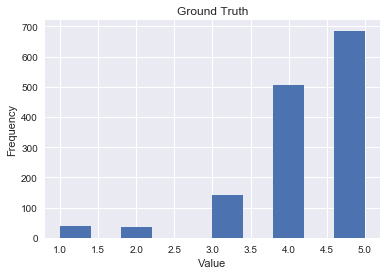

In [138]:
getHistogram('ratingScore', 'Ground Truth')

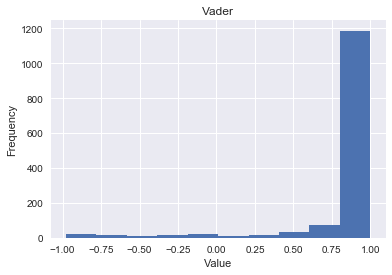

In [139]:
getHistogram('vader', 'Vader')

In [140]:
hotelsdf = finaldf[['hotelName']]

### b) Show a histogram of the number of reviews per hotel. Do you notice any interesting trends? Are these expected?

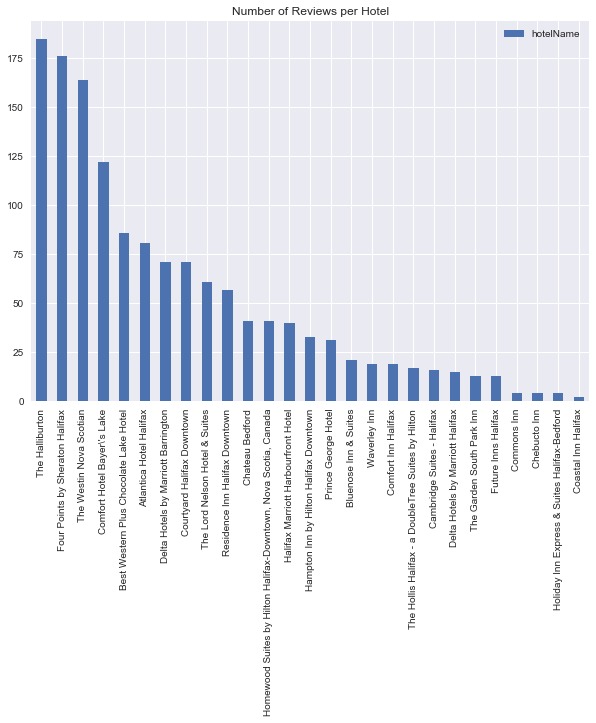

In [141]:
hotelsdf.apply(pandas.value_counts).plot(kind='bar', title = "Number of Reviews per Hotel", figsize = (10,7))


## Boxplots

In [ ]:
#Rank hotels by star rating - show boxplots of vader vs Ground Truth (Star rating)

### a) In two plots, one for ground truth star rating and one for Vader sentiment, show a plot of 5 side-by-side boxplots of these scores.

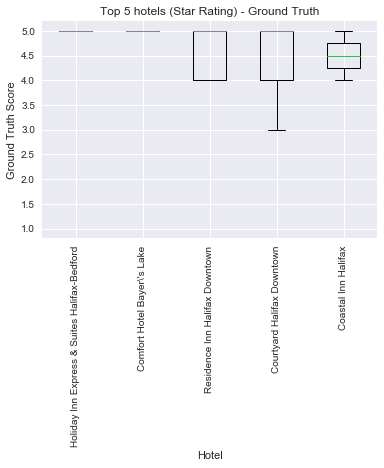

In [175]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].as_matrix()

h1 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[0]]['ratingScore']
h2 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[1]]['ratingScore']
h3 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[2]]['ratingScore']
h4 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[3]]['ratingScore']
h5 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[4]]['ratingScore']

data = [h1, h2, h3, h4, h5]

# multiple box plots on one figure
plt.figure()
plt.title("Top 5 hotels (Star Rating) - Ground Truth")
plt.ylabel("Ground Truth Score")
plt.xlabel("Hotel")
plt.boxplot(data)
plt.xticks(rotation=90)
plt.xticks([1, 2, 3, 4, 5], tp5gthotel['hotelName'].as_matrix())
plt.show()

In [ ]:
rating score

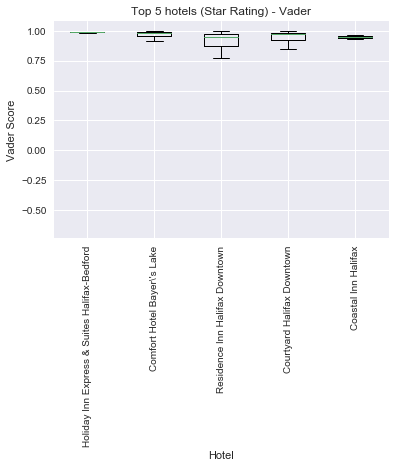

In [188]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].as_matrix()

h1 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[0]]['vader']
h2 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[1]]['vader']
h3 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[2]]['vader']
h4 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[3]]['vader']
h5 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[4]]['vader']

data = [h1, h2, h3, h4, h5]

# multiple box plots on one figure
plt.figure()
plt.title("Top 5 hotels (Star Rating) - Vader")
plt.boxplot(data)
plt.ylabel("Vader Score")
plt.xlabel("Hotel")
plt.xticks(rotation=90)
plt.xticks([1, 2, 3, 4, 5], tp5gthotel['hotelName'].as_matrix())
plt.show()

### b) Report the mean and variance of the ground truth and Vader sentiment scores for the top-5 ranked hotels according to star rating.

In [184]:
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].as_matrix()

h1 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[0]]['ratingScore']
h2 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[1]]['ratingScore']
h3 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[2]]['ratingScore']
h4 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[3]]['ratingScore']
h5 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[4]]['ratingScore']

data = [h1, h2, h3, h4, h5]

print(np.var(h4))


0.4447530251934141


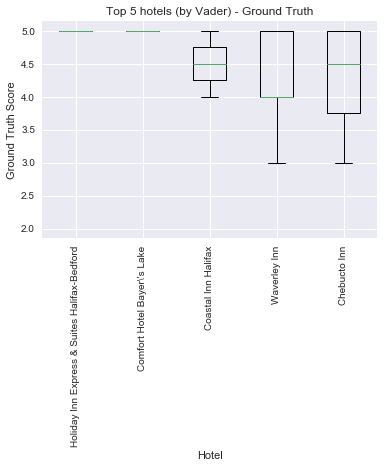

In [181]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfVd.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].as_matrix()

h1 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[0]]['ratingScore']
h2 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[1]]['ratingScore']
h3 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[2]]['ratingScore']
h4 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[3]]['ratingScore']
h5 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[4]]['ratingScore']

data = [h1, h2, h3, h4, h5]

# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.title("Top 5 hotels (by Vader) - Ground Truth")
plt.ylabel("Ground Truth Score")
plt.xlabel("Hotel")
plt.xticks(rotation=90)
plt.xticks([1, 2, 3, 4, 5], tp5gthotel['hotelName'].as_matrix())
plt.show()

## Scatterplots and heatmaps

### a) Show both a scatterplot and heatmap of ground truth score (star rating) versus Vader sentiment score.

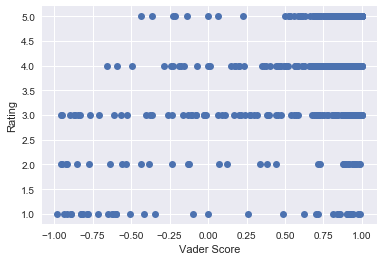

In [114]:
y = finaldf['ratingScore'].as_matrix()
x = finaldf['vader'].as_matrix()
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

In [115]:
from scipy.stats.kde import gaussian_kde

k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

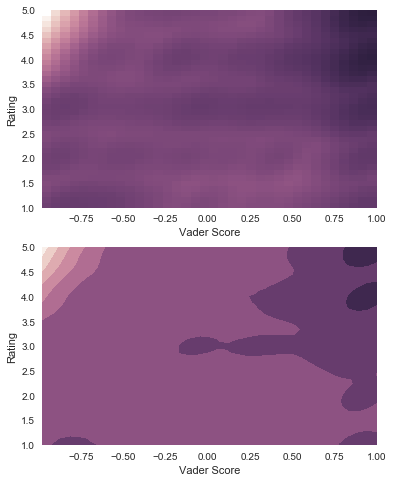

In [116]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

In [119]:
reviewcountdf = finaldf[['hotelName','ratingScore','groundTruth','reviewColumn','vader']]
reviewcountdf['reviewLength'] = reviewcountdf['reviewColumn'].str.len()
reviewcountdf

/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,hotelName,ratingScore,groundTruth,reviewColumn,vader,reviewLength
0,Halifax Marriott Harbourfront Hotel,5,positive,We had a fantastic stay at the Marriott in Hal...,0.9506,280
1,Halifax Marriott Harbourfront Hotel,3,negative,We stayed at Marriot Harbourfront for our anni...,0.9985,4557
2,Halifax Marriott Harbourfront Hotel,5,positive,The name Harbourfront says it all. On the boar...,0.8658,280
3,Halifax Marriott Harbourfront Hotel,4,positive,The absolute best thing about this hotel is th...,0.9855,471
4,Halifax Marriott Harbourfront Hotel,5,positive,If you want a wonderful place to stay in Halif...,0.9637,331
5,Halifax Marriott Harbourfront Hotel,4,positive,I usually stay in this hotel once or twice a y...,0.6249,218
6,Halifax Marriott Harbourfront Hotel,3,negative,Stayed here twice recently for 8 days each tim...,0.9944,1382
7,Halifax Marriott Harbourfront Hotel,1,negative,My husband and I stayed here one night on the ...,0.7156,582
8,Halifax Marriott Harbourfront Hotel,4,positive,My Husband and I stayed at the Marriott in Hal...,0.9903,891
9,Halifax Marriott Harbourfront Hotel,4,positive,We attended an event at the hotel so stayed th...,0.9689,588


### b) Show two scatterplots and two heatmaps of the length of reviews versus each of ground truth score and Vader sentiment score. 

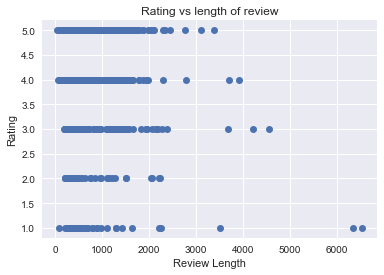

In [125]:
y = reviewcountdf['ratingScore'].as_matrix()
x = reviewcountdf['reviewLength'].as_matrix()
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Review Length')
plt.title('Rating vs length of review')

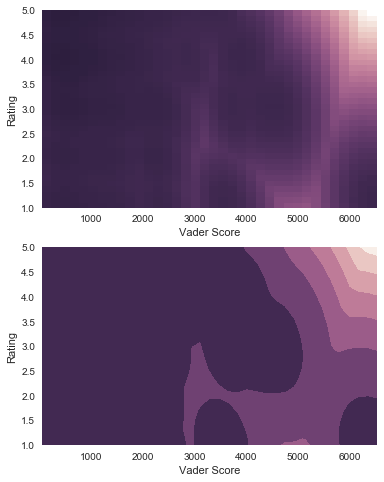

In [126]:
r = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = r(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

### c) Show two scatterplots of the number of reviews per hotel versus each of average ground truth score and average Vader sentiment score. 

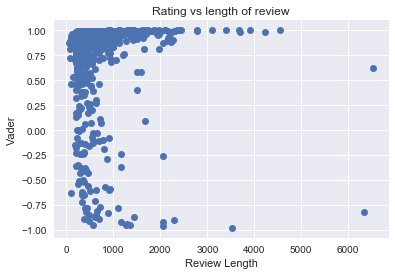

In [127]:
y = reviewcountdf['vader'].as_matrix()
x = reviewcountdf['reviewLength'].as_matrix()
plt.plot(x, y,"o")
plt.ylabel('Vader')
plt.xlabel('Review Length')
plt.title('Rating vs length of review')

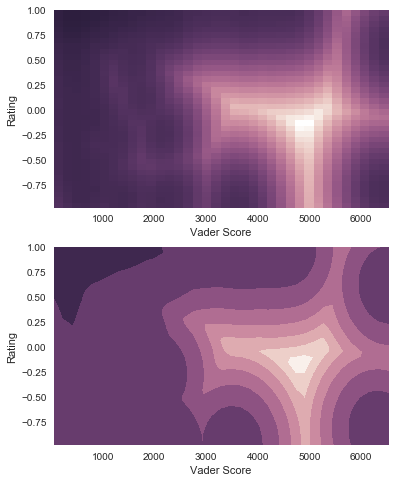

In [128]:
v = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = v(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')